In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
!pip install openpyxl
!pip install qpsolvers
import qpsolvers
!pip install qpsolvers[cvxopt]
!pip install qpsolvers[open_source_solvers]
!pip install qpsolvers[clarabel]
from qpsolvers import solve_qp

In [2]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp((-1)*((np.linalg.norm(x-y))/(2*(l**2))))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp((-1)*(np.linalg.norm(x[i] - y))/(2*(l**2)))
        return vect

In [3]:
max_calculated = pd.read_csv('max_calculated.csv')
max_elemental = pd.read_csv('max_elemental.csv')
list_mxene = pd.read_excel('synthesized-MXenes-MAX.xlsx',sheet_name=0)
list_failed = pd.read_excel('synthesized-MXenes-MAX.xlsx', sheet_name=2)
n_samples = max_elemental.shape[0]

In [4]:
synth_list = pd.unique(list_mxene['MXene'])[:-1]
to_drop = list(range(167,173))
mx_ene_df = list_mxene.drop(labels = to_drop, axis='index')
mx_ene_df = mx_ene_df.drop(['Unnamed: 9','Unnamed: 12','Notes','status','Reference method'],axis=1)
max_elemental['class'] = np.zeros(max_elemental.shape[0])
parents = mx_ene_df['Parent material'].unique()
banned_words = ['+','Mxene','topochemical','reaction', 'or',
               'synthesis','MXene','direct']
complete_parents = []
for i in range(len(parents)):
    inter = parents[i].split()
    for word in range(len(inter)):
        if inter[word] not in banned_words:
            complete_parents.append(inter[word])


for i in range(max_elemental.shape[0]):
    if max_elemental.loc[i,'compound_formula'] in complete_parents:
        max_elemental.loc[i,'class'] = 1

max_elemental = max_elemental.set_index('compound_formula',drop=True)
max_elemental = max_elemental.drop(['M_element', 'A_element', 'X_element'],axis=1)
test_tree = DecisionTreeClassifier().fit(X=max_elemental.drop(['class'],axis=1),
                                          y=max_elemental['class'])

imp_feat = test_tree.feature_importances_
names_feat = test_tree.feature_names_in_
df_imp_feat = pd.DataFrame(np.hstack((imp_feat.reshape(imp_feat.shape[0],1),names_feat.reshape(imp_feat.shape[0],1))))
df_imp_feat.columns = ['features', 'name']
df_imp_feat = df_imp_feat.sort_values('features', ascending=False)

df_diff_z = df_imp_feat[df_imp_feat['features'] != 0]


failed = list_failed['MAX']
failed = list(failed)

for i in max_elemental.index:
    if i in failed:
        max_elemental.loc[i,'class'] = -1


number_of_atoms = np.empty(n_samples)
compteur = 0
for element in max_elemental.index:
    inter = []
    for cara in element:
        if cara in list(str(1234567890)):
            inter.append(cara)
    if len(inter) == 1:
        number_of_atoms[compteur] = int(inter[0]) + 2
    elif len(inter) == 2:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + 1
    elif len(inter) == 3:
        number_of_atoms[compteur] = int(inter[0]) + int(inter[1]) + int(inter[2])
    compteur += 1


columns_name = max_elemental.columns.copy()
normalized = max_elemental.drop(['class'],axis=1).to_numpy()/number_of_atoms.reshape(n_samples,1)
max_elem_norm = pd.DataFrame(normalized)
max_elem_norm['class'] = max_elemental['class'].copy()
max_elem_norm.columns = columns_name
max_elem_norm['compound_name'] = max_elemental.index
max_elem_norm = max_elem_norm.set_index('compound_name',drop=True)

max_elem_norm['class'] = max_elemental['class'].copy()
list_of_imp_names = list(df_diff_z['name'])
list_of_imp_names.append('label')
list_of_imp_names.append('class')
max_elem_norm = max_elem_norm.filter(items=list_of_imp_names, axis=1)
max_elem_norm['label'] = np.zeros(n_samples)
for i in max_elem_norm.index:
    if max_elem_norm.loc[i,'class'] == 1:
        max_elem_norm.loc[i,'label'] = 1
    else:
        max_elem_norm.loc[i,'label'] = -1

positive_samples = max_elem_norm[max_elem_norm['label'] == 1]
unlabelled_samples = max_elem_norm[max_elem_norm['label'] == -1]



In [5]:
svm_train = SVC(kernel='sigmoid', probability = True).fit(X=max_elem_norm.to_numpy()[:,:-2],
                                                          y=max_elem_norm.to_numpy()[:,-1])
probas = svm_train.predict_proba(max_elem_norm.to_numpy()[:,:-2])

In [6]:
proba_gap = np.zeros(n_samples)
for i in range(n_samples):
    proba_gap[i] = probas[i,1] - probas[i,0]


max_elem_norm['proba_gap'] = proba_gap

n_min = 4 #we increase it a bit as the classes are really unbalanced

l_boundary = np.mean(np.sort(max_elem_norm[max_elem_norm['label'] == 1]['proba_gap'])[:n_min])


relab = np.empty(n_samples)
for i in range(n_samples):
    if max_elem_norm.loc[max_elem_norm.index[i],'proba_gap'] < l_boundary:
        relab[i] = -1
    elif max_elem_norm.loc[max_elem_norm.index[i],'label'] == 1 or max_elem_norm.loc[max_elem_norm.index[i],'proba_gap'] >= 0:
        relab[i] = 1
    else:
        relab[i] = 0
max_elem_norm['relab'] = relab

for i in range(n_samples):
    if max_elem_norm.loc[max_elem_norm.index[i],'label'] == 1:
        max_elem_norm.loc[max_elem_norm.index[i],'relab'] = 1





In [7]:
B=100
labeled_data = max_elem_norm[max_elem_norm['relab'] != 0].copy()
output_labeled = labeled_data['relab'].to_numpy()
list_of_index = labeled_data.index
labeled_data = labeled_data.reset_index(drop=True)
labeled_data = labeled_data.to_numpy()[:,:-4]
unlabeled_data = max_elem_norm.drop(index=list_of_index,axis=0)
unlabeled_data = unlabeled_data.to_numpy()[:,:-4]
n_unlabeled = unlabeled_data.shape[0]
n_labels = labeled_data.shape[0]
capital_k = np.zeros((n_labels,n_labels))
kappa = np.zeros(n_labels)


#construction of capital_k
for i in range(n_labels):
    for j in range(i,n_labels):
        capital_k[i,j] = rbf(x=labeled_data[i,:],y=labeled_data[j,:])

capital_k = capital_k + capital_k.T
for i in range(n_labels):
    capital_k[i,i] = 1

capital_k[np.where(np.isnan(capital_k) == True)] = 0

#construction of kappa
ratio_lab_unlab = n_labels/n_unlabeled

for i in range(n_labels):
    vector = np.empty(n_unlabeled)
    for k in range(n_unlabeled):
        vector[k] = rbf(x=labeled_data[i,:],y=unlabeled_data[k,:])    
    kappa[i] = ratio_lab_unlab*np.sum(vector)

kappa = -kappa



ones_transposed = np.ones(n_labels).reshape(1,n_labels)
a_mat = np.vstack((ones_transposed,ones_transposed*-1,
                   np.eye(n_labels),np.eye(n_labels)*-1))
epsilon = (np.sqrt(n_labels)-1)/np.sqrt(n_labels)
ub_mat = np.vstack((n_labels*(1+epsilon),n_labels*(epsilon-1),
                    np.ones(n_labels).reshape(n_labels,1)*B,
                    np.zeros(n_labels).reshape(n_labels,1)))



beta_opti = solve_qp(P=capital_k,q=kappa,G=a_mat,h=ub_mat,solver='cvxopt')


svm_weighted = SVC().fit(X=labeled_data,y=output_labeled,sample_weight=beta_opti)

predictions_weighted = svm_weighted.predict(max_elem_norm.to_numpy()[:,:-4])

positive = 0
true_positive = 0
for i in range(n_samples):
    if predictions_weighted[i] == 1:
        positive += 1
        if max_elem_norm.loc[max_elem_norm.index[i],'class'] == 1:
            true_positive += 1


recall_pgpu = true_positive/max_elem_norm[max_elem_norm['class'] == 1].shape[0]
weird_estim_pgpu = (recall_pgpu**2)/(positive/max_elem_norm.shape[0])
print('the recall of pgpu on train set is :', recall_pgpu, '\n', 
      'the weird metric of pgpu on train set is :', weird_estim_pgpu)

the recall of pgpu on train set is : 0.8666666666666667 
 the weird metric of pgpu on train set is : 1.6905605306799338


In [8]:
svm_weighted = SVC(probability=True).fit(X=labeled_data,y=output_labeled,sample_weight=beta_opti)

predictions_weighted = svm_weighted.predict_proba(max_elem_norm.to_numpy()[:,:-4])[:,1]

In [9]:
max_elem_norm['predictions'] = predictions_weighted

In [10]:
most_probable_pgpu = list(max_elem_norm.sort_values('predictions', ascending=False).head(200).index)

In [11]:
positive_names = list(positive_samples.index)

In [12]:
same_pred = []
for i in positive_names:
    if i in most_probable_pgpu:
        same_pred.append(i)

In [13]:
same_pred

['Ti3AlC2', 'Ti3SiC2', 'V4AlC3', 'Nb4AlC3', 'Ta4AlC3', 'Ti4AlN3']

In [14]:
max_elem_norm.filter(items=failed,axis=0)['predictions']

Mn2GaC    0.000862
Cr2AlC    0.514818
Mo2GaC    0.002979
Name: predictions, dtype: float64

In [15]:
#we achieve better performance with B = 10.000

In [16]:
#Cr2AlC is quite particular because it changes in the opposite direction of Mn2GaC
#and Mo2GaC, meaning that depending on the tuning of certain hyperparameters
#such as B, the first one will have a higher score whereas the other two will see their score
#decrease, and when the two other have a high score, it will have a very low probability

In [17]:
max_calculated = max_calculated.set_index('prettyformula',drop=True)

In [18]:
to_plot = max_calculated.filter(items=most_probable_pgpu,axis=0)

In [19]:
feature_to_plot = to_plot['dH']

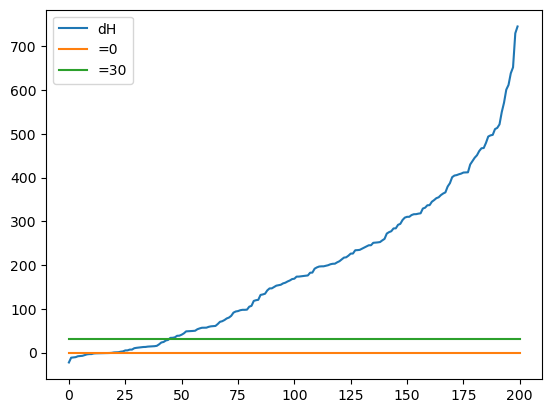

In [20]:
plt.plot(np.sort(feature_to_plot),label='dH')
plt.plot(np.linspace(0,200,3), np.zeros(3),label='=0')
plt.plot(np.linspace(0,200,3),np.ones(3)*30,label='=30')
plt.legend()

In [21]:
#seems to be a little less conclusive than the other methods so far

In [29]:
df_ordered_pred = pd.DataFrame(max_elem_norm[max_elem_norm['relab'] == 1].sort_values(by='predictions',ascending=False)['predictions'])

In [30]:
df_ordered_pred.columns = ['PGPU']
df_ordered_pred = df_ordered_pred.reset_index()

In [32]:
df_ordered_pred['rank_pgpu'] = df_ordered_pred.index

In [34]:
df_ordered_pred = df_ordered_pred.set_index('compound_name')

In [36]:
df_ordered_pred.to_csv(path_or_buf='ordered_predictions_pgpu.csv')